In [1]:
from serpapi import GoogleSearch
import pandas as pd
import pickle

# Scraping

In [2]:
# states = [
#     "Perlis",
#     "Kedah",
#     "Penang",
#     "Perak",
#     "Selangor",
#     "Pahang",
#     "Negeri Sembilan",
#     "Melaka",
#     "Johor",
#     "Kelantan",
#     "Terengganu"]

# terms = ["kilang beras","kilang padi","rice mill"]

# searches = []

# for state in states:
#     for term in terms:
#         params= {
#           "api_key": "415d5974985de7020986ac30c9b2cc40731c869243b1ec0887f71c6f25e4dc09",
#           "device": "desktop",
#           "engine": "google_maps",
#           "type": "search",
#           "google_domain": "google.com",
#           "q": f"{term}, {state}",
#           "hl": "en"
#         }

#         search = GoogleSearch(params)
#         results = search.get_dict()

#         searches.append({"state":state,
#         "term":term,
#         "results":results})
#         print(state,term,"DONE")

# Persist

In [3]:
# with open("serialized/searches_rice_mills2.pkl","wb") as file:
#     pickle.dump(searches,file)

# Reload

In [4]:
with open("serialized/searches_rice_mills.pkl","rb") as file:
    searches = pickle.load(file)

with open("serialized/searches_rice_mills2.pkl","rb") as file:
    searches2 = pickle.load(file)


# Data Extraction

In [5]:
ss = searches + searches2
flat_results = []
for search in ss:
    state = search['state']
    term = search['term']
    if 'local_results' in search['results']: 
        local_results = search['results']['local_results']
    
    for local_result in local_results:
        s = local_result
        d = {k:s[k] for k in ['title','type'] if k in s}
        d['latitude'] = s['gps_coordinates']['latitude']
        d['longitude'] = s['gps_coordinates']['longitude']
        d['state'] = state
        d['searchterm'] = term
        flat_results.append(d)

df = pd.DataFrame(flat_results)

# Data Cleaning

In [6]:
# remove duplicates with same title,type,longitude, & latitude
df2 = df.drop_duplicates(['title','type','longitude','latitude'])
# rename title ==> name
df2.rename(columns = {'title':'name'}, inplace = True)

C:\Users\elvin\AppData\Local\Temp\ipykernel_4136\2821105304.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.rename(columns = {'title':'name'}, inplace = True)


In [7]:
# Visual check
duplicated = df2[df2.duplicated('name')]['name'].values
for dup in duplicated:
    print(df2[df2['name'] == dup])

                                  name         type  latitude   longitude  \
38  Hock Chuan Lee Rice Mill Sdn. Bhd.  Agriculture  6.268888  100.428665   
40  Hock Chuan Lee Rice Mill Sdn. Bhd.          NaN  6.282867  100.390571   

     state searchterm  
38  Perlis  rice mill  
40  Perlis  rice mill  
                name             type  latitude   longitude     state  \
229  Rice wholesaler  Rice wholesaler  3.233351  101.692072  Selangor   
268  Rice wholesaler        Rice mill  3.233351  101.692072  Selangor   

       searchterm  
229  kilang beras  
268     rice mill  
                                   name             type  latitude  \
230  Padiberas Nasional Berhad (BERNAS)  Rice wholesaler  3.017922   
504  Padiberas Nasional Berhad (BERNAS)        Rice mill  5.843675   

      longitude     state    searchterm  
230  101.368629  Selangor  kilang beras  
504  102.368507  Kelantan  kilang beras  


In [8]:
# remove only 229 because the only valid duplicate
df2 = df2.drop(229)

In [9]:
# persist... just incase
with open("serialized/df_ricemills_results.pkl","wb") as file:
    pickle.dump(df2,file)

In [10]:
# reload
with open("serialized/df_ricemills_results.pkl","rb") as file:
    df = pickle.load(file)

In [11]:
# export df just incase
df.to_csv("data/ricemills_locations.csv",index=False)

# Visual QC

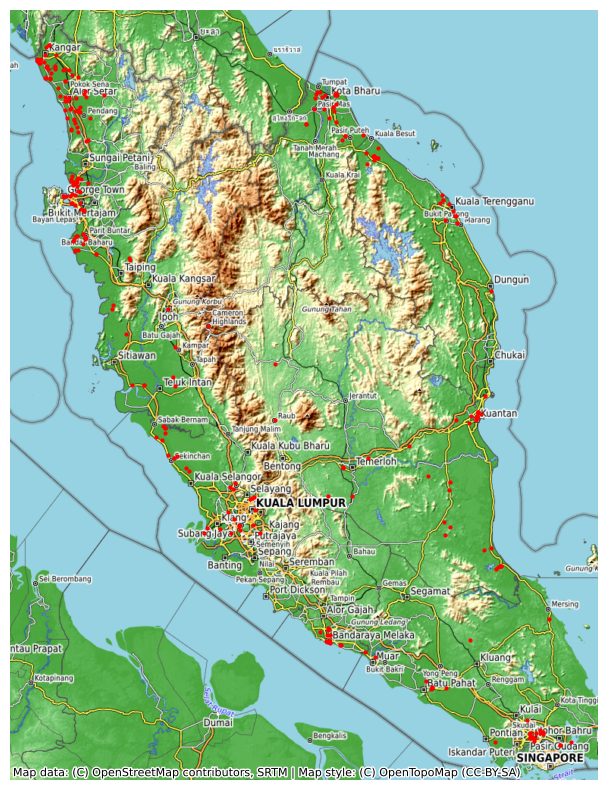

In [26]:
from geopandas import GeoDataFrame
from shapely.geometry import Point
import matplotlib.pyplot as plt
import contextily as cx

geometry = [Point(xy) for xy in zip(df.longitude,df.latitude)]
gdf = GeoDataFrame(df,crs="EPSG:4326",geometry=geometry)
gdf = gdf.to_crs(epsg=3857)
gdf['coords'] = gdf['geometry'].apply(lambda x: x.representative_point().coords[:])
ax = gdf[gdf['longitude']<105].plot(figsize=(20,10),c='red',markersize=4)
cx.add_basemap(ax, source=cx.providers.OpenTopoMap)
# cx.add_basemap(ax, source=cx.providers.Stamen.TonerLabels)
ax.set_axis_off()
# for idx, row in gdf.iterrows():
#     plt.annotate(text=row['name'],xy=row['coords'][0])